In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

---
1. Total Scope 1 and 2 Emissions (tons of CO2e): This is the dependent variable that represents the combined direct and indirect greenhouse gas emissions.
2. Charlie (in mil USD): Represents costs incurred on the emission.
3. Romeo (mil USD): Represent production value of emission.
4. Echo (Number): The total number of community members affected.
5. Alpha (mil USD): Total market capital of the company.
---

#### Methodology for Model Development

1. Describe the methodology applied for developing Scope 1 and 2 emission estimation models.
2. Justify the choice of the model/methodology using statistical logic and reasoning.
---
#### Model Results Summary
1. Provide an overview and summary of the results obtained from the developed models.
Model Validation
2. Briefly explain the model validation process.
3. Justify the choice of metrics or validation process used, highlighting their relevance and effectiveness.

---

#### Sector Analysis
1. Identify and analyze which sectors have higher Scope 1 and 2 emissions and which have lower
emissions.
2. Explain the reasons behind the differences in emission levels across sectors.
---
#### Data Requirements for Model Improvement
1. Identify additional data that could improve the accuracy and reliability of the emission
estimation models.
2. Explain how the additional data would enhance the models and lead to better results.o better results.

In [17]:
# %cd ..

In [18]:
data_path = r"ISSCaseStudy_Sample data for modelling.csv"

df = pd.read_csv(data_path)
df["Total S1+S2 (tCo2e)"] = df["Total S1+S2 (tCo2e)"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company Identifier   872 non-null    int64  
 1   Total S1+S2 (tCo2e)  872 non-null    int32  
 2   Subsector Name       872 non-null    object 
 3   Charlie (milUSD)     615 non-null    float64
 4   Alpha (milUSD)       797 non-null    float64
 5   Romeo (milUSD)       808 non-null    float64
 6   Echo                 753 non-null    float64
dtypes: float64(4), int32(1), int64(1), object(1)
memory usage: 44.4+ KB


#### Data Preprocessing

- Since there are 872 rows in a dataframe and out of which charlie has the the most number of NaN's followed by 75 in Alpha, 64 in Alpha and 119 in Echo, so dropping the value would significantly result in data loss.
- There are multiple ways to handle NaN's but I am going with filling those NaN's with their respective sectore wise median value

In [19]:
## Nan values per column
df.isna().sum()

Company Identifier       0
Total S1+S2 (tCo2e)      0
Subsector Name           0
Charlie (milUSD)       257
Alpha (milUSD)          75
Romeo (milUSD)          64
Echo                   119
dtype: int64

In [20]:
sector_medians = df.groupby("Subsector Name")[["Charlie (milUSD)",
                             "Alpha (milUSD)","Romeo (milUSD)",
                             "Echo"]].median().T.to_dict()

In [21]:
def fill_missing_values(row):
    sector = row['Subsector Name']
    for col in ["Charlie (milUSD)","Alpha (milUSD)","Romeo (milUSD)","Echo"]:
        if pd.isna(row[col]) and sector in sector_medians:
            row[col] = sector_medians[sector][col]
    return row

df = df.apply(fill_missing_values, axis = 1)

In [22]:
# # Create new features
# df['Energy_Intensity'] = df['Total S1+S2 (tCo2e)'] / df['Charlie (milUSD)']
# df['Emissions_per_Production'] = df['Total S1+S2 (tCo2e)'] / df['Romeo (milUSD)']
# df['Raw_Material_Intensity'] = df['Total S1+S2 (tCo2e)'] / df['Alpha (milUSD)']

# # Normalize features by sector medians
# for sector in sector_medians.keys():
#     mask = df['Subsector Name'] == sector
#     df.loc[mask, 'Normalized_Charlie'] = df.loc[mask, 'Charlie (milUSD)'] / sector_medians[sector]['Charlie (milUSD)']
#     df.loc[mask, 'Normalized_Alpha'] = df.loc[mask, 'Alpha (milUSD)'] / sector_medians[sector]['Alpha (milUSD)']
#     df.loc[mask, 'Normalized_Romeo'] = df.loc[mask, 'Romeo (milUSD)'] / sector_medians[sector]['Romeo (milUSD)']
#     df.loc[mask, 'Normalized_Echo'] = df.loc[mask, 'Echo'] / sector_medians[sector]['Echo']

# # Relative Emission Intensity
# sector_emissions_median = df.groupby('Subsector Name')['Total S1+S2 (tCo2e)'].median().to_dict()
# df['Relative_Emission_Intensity'] = df.apply(lambda x: x['Total S1+S2 (tCo2e)'] / sector_emissions_median[x['Subsector Name']], axis=1)


__Entries in total marker capital of the company, production value of emmision and total number of community member can't be negative and represents data error, there are not significant number of values below 0, so dropping them won't result in huge data loss__

In [23]:
df.describe()

,Company Identifier,Total S1+S2 (tCo2e),Charlie (milUSD),Alpha (milUSD),Romeo (milUSD),Echo
count,872.000000,8.720000e+02,838.000000,872.000000,872.000000,872.000000
mean,436.500000,2.464757e+06,6481.464870,3915.920496,11590.125072,27880.199885
std,251.869014,1.077697e+07,20173.407364,10452.772375,27104.154797,57113.328425
min,1.000000,1.600000e+01,0.000000,-2795.930473,-12611.749730,-96498.000000
25%,218.750000,1.831850e+04,162.403196,252.389670,1208.645307,2766.000000
50%,436.500000,1.128010e+05,1038.834952,977.934669,2966.695160,9506.000000
75%,654.250000,8.788098e+05,3644.120278,3113.841986,8906.832576,26076.500000
max,872.000000,1.950000e+08,220651.529600,116843.562800,272373.980200,664496.000000


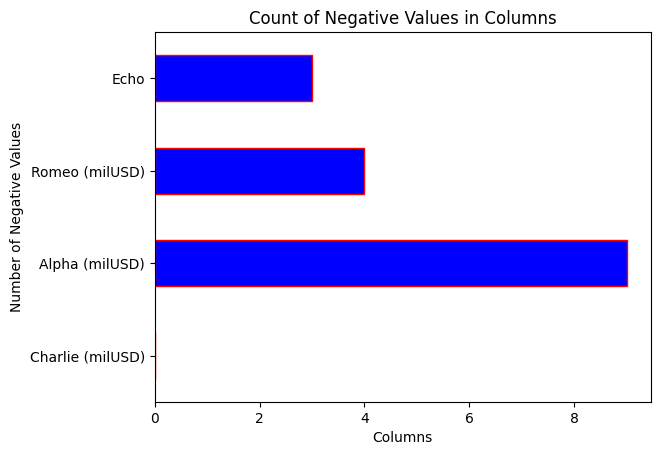

In [24]:
negative_counts = df[['Charlie (milUSD)', 'Alpha (milUSD)', 'Romeo (milUSD)', 'Echo']].apply(lambda x: (x < 0).sum())

negative_counts.plot(kind='barh', color='blue', edgecolor='red')
plt.title('Count of Negative Values in Columns')
plt.xlabel('Columns')
plt.ylabel('Number of Negative Values')
plt.show()

In [25]:
df = df[(df['Charlie (milUSD)'] >= 0) & 
                (df['Alpha (milUSD)'] >= 0) & 
                (df['Romeo (milUSD)'] >= 0) & 
                (df['Echo'] >= 0)]
df

,Company Identifier,Total S1+S2 (tCo2e),Subsector Name,Charlie (milUSD),Alpha (milUSD),Romeo (milUSD),Echo
0,1,6399,Software,1095.971939,213.081635,2650.219949,8558.0
1,2,59990,Software,1270.020324,1061.630736,8869.070062,21357.0
2,3,296160,Specialty Chemicals,6292.864579,2018.705686,10689.439260,34500.0
3,4,960000,Specialty Chemicals,2107.656246,2956.230233,3302.499773,5900.0
4,5,253641,Health Care Services,8208.619341,1746.387752,11090.105310,61000.0
...,...,...,...,...,...,...,...
867,868,1423965,Oil & Gas Storage & Transportation,3183.102765,2087.455814,3668.409827,3269.5
868,869,16898,Automobiles,993.242228,408.682552,1431.694628,2532.0
869,870,2983522,Coal,1244.507989,1587.863458,1937.988418,0.0
870,871,2798000,Specialty Chemicals,1325.912145,778.332346,5874.240000,4639.0


<Axes: xlabel='milUSD', ylabel='Subsector Name'>

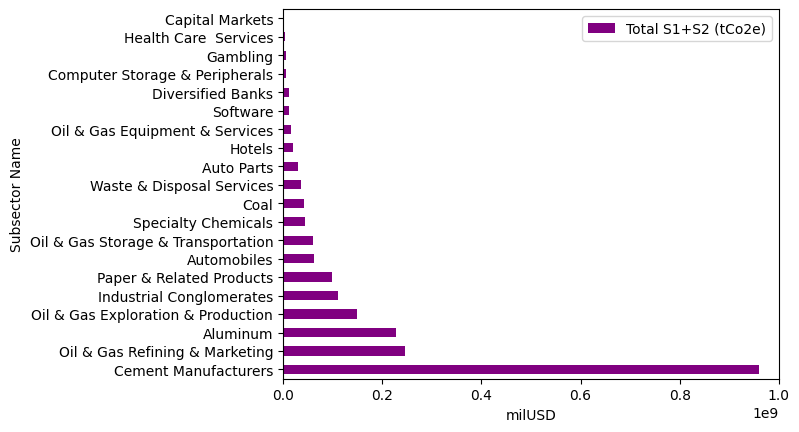

In [26]:
## Sector wise Analysis
# High emission sectors
df.groupby("Subsector Name")["Total S1+S2 (tCo2e)"].sum().sort_values(ascending = False).plot(kind = "barh", xlim = (0, 1000000000),
                                                                                             xlabel = "milUSD", color  = "Purple", legend  = True)

---
### Top 5 Subsector Emissions:
- Cement Manufacturers
- Oil & Gas Refining & Marketing
- Aluminum
- Oil & Gas Exploration & Production
- Industrial Conglomerates
---
### Last 5 Subsector Emissions:
- Regional Banks
- Capital Markets
- Health Care Services
- Gambling
- Computer Storage & Peripherals
---
- __Operational Differences: Industries like Specialty Chemicals, Cement Manufacturing, and Oil & Gas involve processes that inherently produce more emissions, such as chemical reactions, high heat requirements, and direct fossil fuel use.__
- __Energy Efficiency: Sectors with lower emissions, such as Software, often benefit from more energy-efficient operations and less dependence on heavy industrial equipment.__